<a href="https://colab.research.google.com/github/SatoSim/xray_project/blob/main/K_means_%26_PCA_xray.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing images

- Extracting the images from zip filed in git repository
- Since pneumonia and normal images are in different files due to size limitations when pushing to git repo, I create separate dataframes. I then concatenate and shuffle dataframes.

In [ ]:
import requests
import pickle
import numpy as np
import pandas as pd
from PIL import Image

from matplotlib import pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import seaborn as sns
sns.set()

from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

import cv2
import os

import shutil
import requests
from zipfile import ZipFile
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.cluster import kmeans_plusplus


In [ ]:
import requests
import zipfile
import pickle

# URL of the zip pickled file
url = "https://github.com/SatoSim/xray/raw/main/df_normal.zip"
# Download the zip file
response = requests.get(url)

if response.status_code == 200:
    # Save the zip file locally
    with open("df_normal.zip", "wb") as f:
        f.write(response.content)

    # Extract the pickled file from the zip archive
    with zipfile.ZipFile("df_normal.zip", "r") as zipf:
        zipf.extractall()

    # Load the pickled data into a DataFrame
    with open("df_normal.pkl", "rb") as f:
        df = pickle.load(f)

    # Now you can work with the DataFrame
    print(df.head())
else:
    print("Failed to download the zip pickled file")

# URL of the zip pickled file
url = "https://github.com/SatoSim/xray/raw/main/df_pneumonia3.zip"
# Download the zip file
response = requests.get(url)

if response.status_code == 200:
    # Save the zip file locally
    with open("df_pneumonia3.zip", "wb") as f:
        f.write(response.content)

    # Extract the pickled file from the zip archive
    with zipfile.ZipFile("df_pneumonia3.zip", "r") as zipf:
        zipf.extractall()

    # Load the pickled data into a DataFrame
    with open("df_pneumonia3.pkl", "rb") as f:
        df_tail = pickle.load(f)

    # Now you can work with the DataFrame
    print(df_tail.head())
else:
    print("Failed to download the zip pickled file")


   Label                                          flattened
0      0  [0.22745098039215686, 0.22745098039215686, 0.2...
1      0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
2      0  [0.08627450980392157, 0.08627450980392157, 0.0...
3      0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
4      0  [0.0392156862745098, 0.0392156862745098, 0.039...
      Label                                          flattened
2841      1  [0.06666666666666667, 0.06666666666666667, 0.0...
722       1  [0.788235294117647, 0.788235294117647, 0.78823...
1705      1  [0.09411764705882353, 0.09411764705882353, 0.0...
385       1  [0.615686274509804, 0.615686274509804, 0.61568...
985       1  [0.00784313725490196, 0.00784313725490196, 0.0...


In [ ]:
df = pd.concat([df, df_tail], ignore_index=True)

<Axes: xlabel='count'>

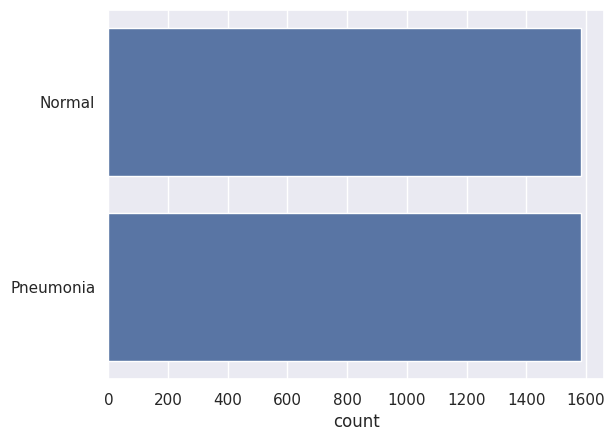

In [ ]:
df["Label"].value_counts()
l = []
for i in df["Label"]:
    if(i == 1):
        l.append("Pneumonia")
    else:
        l.append("Normal")
sns.countplot(l)

In [ ]:
df_shuffled = df.sample(frac=1, random_state=42)
df_shuffled.reset_index(drop=True, inplace=True)

In [ ]:
df_shuffled.head()

,Label,flattened
0,0,"[0.1450980392156863, 0.1450980392156863, 0.145..."
1,0,"[0.3254901960784314, 0.3254901960784314, 0.325..."
2,0,"[0.2784313725490196, 0.2784313725490196, 0.278..."
3,1,"[0.15294117647058825, 0.15294117647058825, 0.1..."
4,1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [ ]:
flattened_images = [img for img in df_shuffled['flattened']]

# PCA
- Principal component analysis decreases number of dimensions of flattened images. This makes it easier for KNN to run.

In [ ]:
variance = 0.70
pca = PCA(variance)
pca_result = pca.fit_transform(flattened_images)



In [ ]:
#Dividing PCA result into testing and training set
X_train, X_test, y_train, y_test = train_test_split(pca_result, df_shuffled["Label"] , test_size=0.2, random_state=42)

# Kmeans
 - Interesting to note that results from Kmeans do not really indicate anything. I was testing to see if there was a clear distinction we could extract with centroids but image split is not clear.

In [ ]:
# Apply KMeans clustering
kmeans = KMeans(n_clusters=2)  # You can adjust the number of clusters as needed
kmeans.fit(pca_result)

# Add cluster labels to DataFrame
df_shuffled['Cluster'] = kmeans.labels_

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


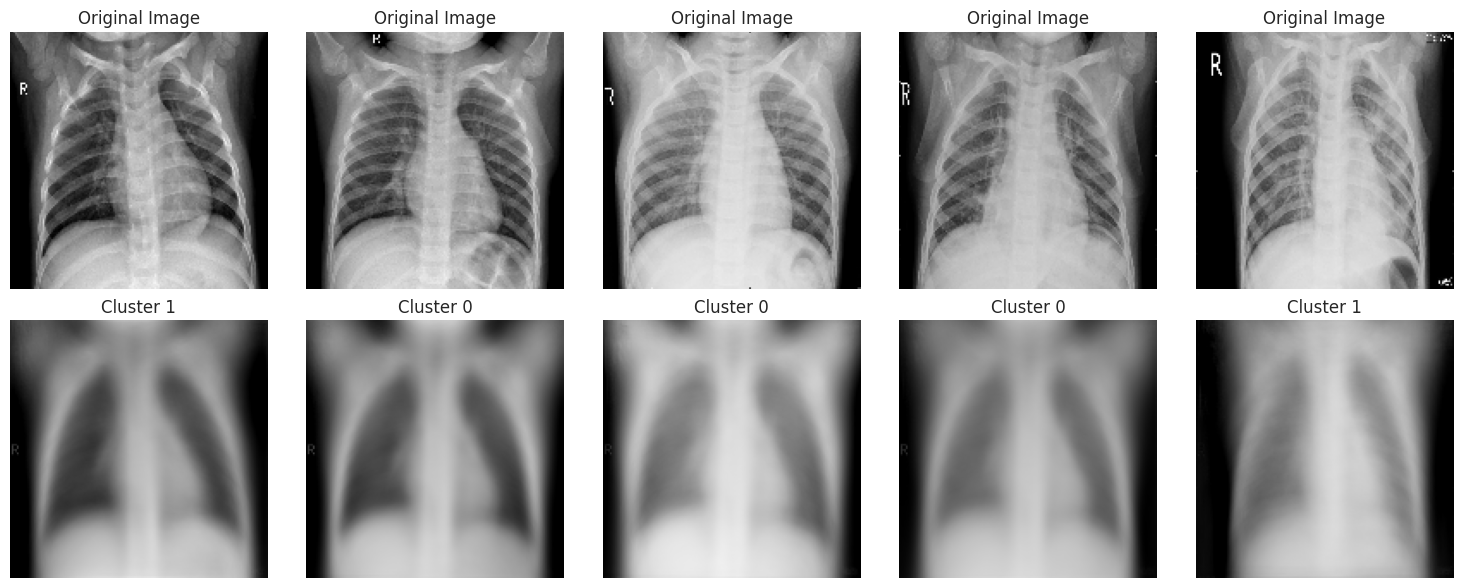

In [ ]:
num_images = 5  # Number of images to visualize
fig, axes = plt.subplots(2, num_images, figsize=(15, 6))

for i in range(num_images):
    image_index = df_shuffled.index[i]
    image = pca.inverse_transform(pca_result[image_index]).reshape(150,150,3)
    cluster_label = df_shuffled['Cluster'][image_index]
    axes[0, i].imshow(flattened_images[image_index].reshape(150,150,3), cmap='gray')
    axes[0, i].set_title(f"Original Image")
    axes[0, i].axis('off')
    axes[1, i].imshow(image, cmap='gray')
    axes[1, i].set_title(f"Cluster {cluster_label}")
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()


In [ ]:
cross_tab = pd.crosstab(df_shuffled['Label'], df_shuffled['Cluster'])

# Display the cross-tabulation
cross_tab

Cluster,0,1
Label,,
0,786,797
1,882,701


# Implementing KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=33)
neigh.fit(X_train, y_train)


KNeighborsClassifier(n_neighbors=33)

In [ ]:
k_list = []
cv_scores = []

for k in range(20, 55):
  neigh = KNeighborsClassifier(n_neighbors=k)
  neigh.fit(X_train, y_train)
  y_pred = neigh.predict(X_test)
  accuracy = accuracy_score(y_test, y_pred)
  k_list.append(k)
  cv_scores.append(accuracy)


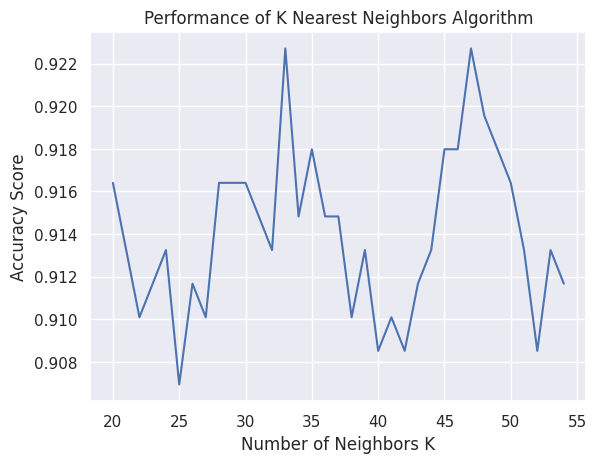

In [ ]:
plt.figure()
plt.title('Performance of K Nearest Neighbors Algorithm')
plt.xlabel('Number of Neighbors K')
plt.ylabel('Accuracy Score')
plt.plot(k_list, cv_scores)

plt.show()

# Evaluating the model

In [ ]:
y_pred = neigh.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


Accuracy: 0.9227129337539433


In [ ]:
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[304  24]
 [ 25 281]]


In [ ]:
scores = cross_val_score(neigh, pca_result, df_shuffled["Label"] , cv = 10, scoring = 'accuracy')
print(scores)
cv_score=scores.mean()
print(cv_score)

[0.90851735 0.94006309 0.93059937 0.91167192 0.93375394 0.9022082
 0.90822785 0.89873418 0.90822785 0.91139241]
0.9153396158607195


In [ ]:
print(classification_report(y_test, y_pred, target_names = ['Normal','Pneumonia']))

              precision    recall  f1-score   support

      Normal       0.92      0.93      0.93       328
   Pneumonia       0.93      0.91      0.92       306

    accuracy                           0.92       634
   macro avg       0.92      0.92      0.92       634
weighted avg       0.92      0.92      0.92       634



In [ ]:
cross_tab = pd.crosstab(y_test, y_pred)

In [ ]:
cross_tab

col_0,0,1
Label,,
0,304,24
1,25,281
